Fait par Steven BRADLEY, Saly YANG, Thomas FERRANDIS

In [38]:
! pip install opencv-python
! pip install Pillow

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import csv
import pandas as pd

import openpyxl

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

# Comptage de Points

In [2]:
def add_zeros(number):
    # Convert the number to a string
    number_str = str(number)

    # Check the length of the string
    if len(number_str) >= 3:
        # If the number has three or more digits, return it as is
        return number_str
    else:
        # If the number has less than three digits, add leading zeros
        return number_str.zfill(3)

In [3]:
def mask_range(pixel,tolerance,image):
    """
    Create a binary mask for a specific pixel value and tolerance range.

    Args:
        pixel: The pixel value to create the mask for.
        tolerance: The range of acceptable values around the pixel value.

    Returns:
        binary_mask: Binary mask representing pixels within the tolerance range.

    Note:
        This function assumes that the 'thresholded_image_or' variable is available.

    """
    
    # Create lower and upper bounds arrays
    lower_bound = pixel - tolerance
    upper_bound = pixel + tolerance

    # Create a binary mask based on the grayscale image and RGB comparison
    binary_mask = cv2.inRange(image, lower_bound, upper_bound)
    return binary_mask

In [4]:
#PARAMETRES

# Load the Excel file
workbook = openpyxl.load_workbook('BDD.xlsx')
sheet = workbook['Feuille 1']

num_ = 8
num = add_zeros(num_)

grey_name = 'image_gris_4.png'
seg_name = 'training/im-'+num+'_seg.png'
#seg_name = 'segmentation_mask.png'

image_name = 'training/im-'+num+'_im.png'
#image_name = 'ladybug_image.png'

In [5]:
def ouverture(nom):
    # Ouverture et sauvegarde image nouveau format
    image = cv2.cvtColor(cv2.imread(nom), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

In [6]:
def ouverture_et_nvformat_seg(nom_image,nom_gris):
    # Ouverture segmentation
    image_t = Image.open(nom_image).convert("L")
    plt.imshow(image_t, cmap='Greys')
    plt.axis('off')
    plt.savefig(nom_gris, bbox_inches='tight', pad_inches=0)

In [7]:
def ouverture_et_nvformat_seg2(nom_image,nom_gris):
    """image_t = Image.open(nom_image).convert("L")
    image_t.save(nom_gris)"""
    
    
    # Convert the image to grayscale
    image_t = Image.open(nom_image).convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(image_t)

    # Create a new grayscale image using the 'L' mode
    image_greyscale = Image.fromarray(image_array, mode='L')

    # Save the image with the 'Greys' colormap
    image_greyscale.save(nom_gris)

In [8]:
def remove_background(image):
    # Get the RGB values of the first pixel
    target = np.copy(image[0][0]).item()

    binary_mask = mask_range(target,1,thresholded_image_or)

    # Invert the binary mask to allow everything except the pixel to be masked out
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Apply the mask to the original grayscale image to extract the pixels
    result = cv2.bitwise_and(image, image, mask=inverted_mask)

    return result

In [9]:
def carapace_pixel_masque(image):
    
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 1)

    # Get the unique pixel values and their counts
    unique_pixels, counts = np.unique(pixels, return_counts=True)

    # Sort the pixel counts in descending order
    sorted_indices = np.argsort(counts)[::-1]

    # Get the two most common pixel values
    most_common_pixels = unique_pixels[sorted_indices[:2]]

    background_color = np.array([0])

    most_common_pixels_not_background = (
        most_common_pixels[1] if most_common_pixels[0]==0 else most_common_pixels[0]
    )    

    background_px = most_common_pixels_not_background.item()
    caparace_mask = mask_range(background_px,0,image)

    # Apply the mask to the original grayscale image to extract the pixels
    result = cv2.bitwise_and(image, image, mask=caparace_mask)

    _, thresh_image_mask = cv2.threshold(result, background_px-1, 255, cv2.THRESH_BINARY)
    
    return thresh_image_mask
    

In [10]:
def find_avgcolor(image,mask):

    # Définir les valeurs RVB des couleurs prédéfinies
    colors = {
        'Rouge': [(255, 0, 0), (220, 20, 60), (178, 34, 34), (205, 92, 92), (255, 99, 71), (255, 165, 0), (255, 140, 0), (255, 127, 80), (255, 69, 0), (255, 128, 0)],
        'Noir': [(0, 0, 0)],
        'Jaune': [(255, 255, 0), (255, 215, 0), (255, 218, 185), (255, 250, 205), (240, 230, 140)]
    }

    # Obtenir les pixels de la carapace à partir de l'image masquée
    carapace_pixels = image[mask != 0]

    # Calculer la couleur moyenne de la carapace
    mean_color = np.mean(carapace_pixels, axis=0)
    mean_color = mean_color.astype(int)

    # Inverser l'ordre des composantes RVB
    mean_color = mean_color[::-1]

    # Afficher les valeurs RVB de la couleur moyenne
    #print("Couleur moyenne de la carapace (RVB) :", mean_color)

    # Calculer la distance euclidienne entre la couleur moyenne et chaque couleur prédéfinie en utilisant l'espace RGB
    distances = {color: min(np.linalg.norm(mean_color - rgb) for rgb in color_values) for color, color_values in colors.items()}

    # Trouver la couleur la plus proche
    closest_color = min(distances, key=distances.get)

    # Afficher les distances entre la couleur moyenne et chaque couleur prédéfinie
    #print("Distances :", distances)

    # Convertir la couleur moyenne en représentation hexadécimale (RVB)
    mean_color_hex = '#{:02x}{:02x}{:02x}'.format(mean_color[0], mean_color[1], mean_color[2])
    #print("Couleur moyenne de la carapace (hex) :", mean_color_hex)

    #print("Couleur la plus proche :", closest_color)
    
    return closest_color


In [11]:
def invert_mask(mask,image_nobackground):
    # Invert the binary mask to allow everything except the pixel to be masked out
    inverted_caparace_mask = cv2.bitwise_not(mask)
    not_result = cv2.bitwise_and(image_nobackground, image_nobackground, mask=inverted_caparace_mask)
    _, inverted_mask = cv2.threshold(not_result, 0, 255, cv2.THRESH_BINARY)
    return inverted_mask

In [12]:
def showcontour(contours,text):
    blobs_image = np.zeros_like(image)
    
    for contour in contours:
        cv2.drawContours(blobs_image, [contour], 0, (255), -1)
        
    cv2.imshow(text, blobs_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [13]:
def erode(image,show = True):
    nb_points = 0
    
    kernel = np.ones((3, 3), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)

    # Find contours on the edges
    contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert contours tuple to a list
    contours_list = list(contours)

    # Find the contour with the maximum area
    max_contour = max(contours_list, key=cv2.contourArea)

    # Create a new list without the contour with the maximum area
    contours_list = [contour for contour in contours_list if not np.array_equal(contour, max_contour)]
    
    if(show):
        for x in contours:
            print('area :',cv2.contourArea(x))
            print('circularity',((4 * np.pi * cv2.contourArea(x)) / (cv2.arcLength(x, True) ** 2)))



    # Filter contours based on circularity
    circularity = 0.3
    circularity_contours = [contour for contour in contours if cv2.contourArea(contour) > 0 and ((4 * np.pi * cv2.contourArea(contour)) / (cv2.arcLength(contour, True) ** 2)) > circularity]
    
    mask = np.zeros_like(image)

    # Draw the filtered contours on the mask
    cv2.drawContours(mask, circularity_contours, -1, 255, thickness=cv2.FILLED)
    
    # Apply the mask to the original image
    contours_im = cv2.bitwise_and(image, image, mask=mask)
    
    #circularity_single = 0.6
    #circularity_nondouble = [contour for contour in contours if cv2.contourArea(contour) > 0 and ((4 * np.pi * cv2.contourArea(contour)) / (cv2.arcLength(contour, True) ** 2)) > circularity_single]
    
    nb_points = len(circularity_contours)
    
    if(show):
        #for x in circularity_contours:
            #print('area :',cv2.contourArea(x))
            #print('circularity',((4 * np.pi * cv2.contourArea(x)) / (cv2.arcLength(x, True) ** 2)))
        
        
        cv2.imshow('Not eroded', image)
        cv2.imshow('Eroded', eroded_image)

        cv2.imshow('Eroded + Contours', contours_im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    return circularity_contours,nb_points

1
2
3


C:\Users\steve_ao846tt\AppData\Local\Temp\ipykernel_13484\2323157594.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
   Image_id Couleurs Points
0    im-001    Rouge     14
1    im-002    Rouge      5
2    im-003    Rouge      4
3    im-004    Rouge     12
4    im-005    Rouge      3
5    im-006    Rouge     13
6    im-007    Rouge     17
7    im-008     Noir      3
8    im-009    Rouge      7
9    im-010    Rouge      6
10   im-011    Rouge     15
11   im-012    Rouge     19
12   im-013    Rouge     10
13   im-014    Rouge     11
14   im-015    Rouge      5
15   im-016    Rouge      7
16   im-017    Rouge      4
17   im-018    Rouge     11
18   im-019     Noir      6
19   im-020    Rouge      1
20   im-021    Rouge      5
21   im-022     Noir      5
22   im-023     Noir      6
23   im-024    Rouge      5
24   im-025     Noir      7
25   im-026    Rouge      7
26   im-027    Rouge      6
27   im-028    Rouge      5
28   im-029    Rouge      5
29   im-030    Rouge     

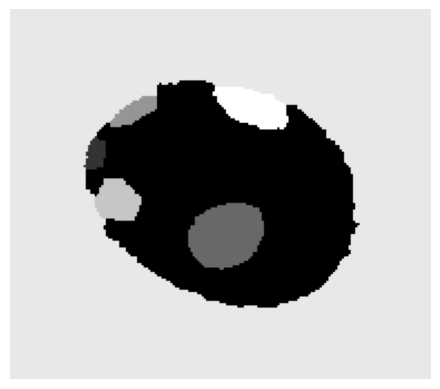

In [57]:
df = pd.DataFrame(columns=['Image_id','Couleurs','Points'])

backgroundless_images = []

for x in range(1,51):
    print(x)
    seg_name = 'test/im-'+add_zeros(x)+'_seg.png'
    image_name = 'test/im-'+add_zeros(x)+'_im.png'
    grey_name = 'grey_image_temp.png'

    ouverture_et_nvformat_seg(seg_name,grey_name)
    thresholded_image_or = cv2.imread(grey_name, cv2.IMREAD_GRAYSCALE)

    # Find black pixels (pixels with intensity 0)
    black_pixels = np.where(thresholded_image_or == 0)

    # Replace black pixels with a shade of grey (intensity 127)
    thresholded_image_or[black_pixels] = 127

    backgroundless = remove_background(thresholded_image_or)

    mask_carapace = carapace_pixel_masque(backgroundless)

    image = cv2.imread(image_name)
    image = cv2.resize(image, (mask_carapace.shape[1], mask_carapace.shape[0]))

    assetBackgroundless = True
    if assetBackgroundless:
        _, tresh_backgroundless = cv2.threshold(backgroundless, 1, 255, cv2.THRESH_BINARY)
        backgroundless_masked_image = cv2.bitwise_and(image, image, mask=tresh_backgroundless)
        backgroundless_images.append(backgroundless_masked_image)

    masked_image = cv2.bitwise_and(image, image, mask=mask_carapace)

    invertmask = invert_mask(mask_carapace,backgroundless)

    show = False
    if show:
        cv2.imshow('1 - thresholded_image_or', thresholded_image_or) 
        cv2.imshow('BACKGROUNDLESS', backgroundless)    
        cv2.imshow('MASQUE AVANT INVERT', mask_carapace)
        cv2.imshow('MASQUE INVERT ', invertmask)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    contours,pts = erode(invertmask,False)

    

    # Create a new row to append
    new_row = pd.DataFrame({'Image_id' : ['im-'+add_zeros(x)] ,'Points': [pts],'Couleurs': [find_avgcolor(masked_image,mask_carapace)]})
    # Append the new row to the data frame
    df = df.append(new_row, ignore_index=True)
        
print(df)

In [50]:
# Load the data from the CSV file
data = pd.read_excel('BDD-TEST.xlsx')

# Separate the features (X) and the target variables (y)
X = data[['Points', 'Couleurs']]
y = data['Race Officielle']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the columns to be encoded using one-hot encoding
columns_to_encode = ['Couleurs']

# Create the ColumnTransformer object for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), columns_to_encode)],
    remainder='passthrough'
)

# Apply preprocessing on the training data
X_train_encoded = preprocessor.fit_transform(X_train)

# Apply preprocessing on the validation data
X_val_encoded = preprocessor.transform(X)

# Apply preprocessing on the test data
X_test_encoded = preprocessor.transform(X_test)

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Train the decision tree on the training data
clf.fit(X_train_encoded, y_train)

# Predict the classes for the test data
y_pred = clf.predict(X_test_encoded)

# Display the classification report
print(classification_report(y_test, y_pred))

# Evaluate the model's performance
accuracy = clf.score(X_test_encoded, y_test)
print("Accuracy:", accuracy)


              precision    recall  f1-score   support

           A       0.97      0.97      0.97        32
           E       0.96      0.96      0.96        28

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

Accuracy: 0.9666666666666667


In [51]:
# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame({'Prediction': y_pred})

# Count the number of European and Asian ladybugs
count = predictions_df['Prediction'].value_counts()

# Display the number of European and Asian ladybugs
print('Number of European ladybugs:', count['E'])
print('Number of Asian ladybugs:', count['A'])

Number of European ladybugs: 28
Number of Asian ladybugs: 32


In [52]:
y_pred = np.where(y_pred == 'E', 0, y_pred)
y_pred = np.where(y_pred == 'A', 1, y_pred)
data = pd.DataFrame({'y_pred': y_pred})
print(data)

   y_pred
0       1
1       0
2       1
3       0
4       0
5       0
6       1
7       1
8       1
9       1
10      1
11      1
12      0
13      0
14      1
15      1
16      1
17      1
18      1
19      0
20      0
21      1
22      0
23      1
24      0
25      0
26      1
27      1
28      0
29      1
30      1
31      1
32      1
33      0
34      1
35      1
36      0
37      1
38      1
39      0
40      0
41      0
42      1
43      0
44      0
45      1
46      1
47      1
48      0
49      1
50      0
51      0
52      1
53      0
54      0
55      1
56      0
57      0
58      0
59      0


In [58]:
# The test data (X_new)
X_new = df[['Points', 'Couleurs']]

# Apply the same preprocessing transformations as for the training data
X_new_encoded = preprocessor.transform(X_new)

# Use the trained model to make predictions on the new ladybug data
y_pred_new = clf.predict(X_new_encoded)

# Print the predictions for the new ladybugs
data_new = pd.DataFrame({'y_pred_new': y_pred_new})


points_column = df[['Image_id', 'Points']]
combined_df = pd.concat([points_column, data_new], axis=1)


combined_df = pd.concat([points_column, data_new], axis=1)

y_pred_new = np.where(y_pred_new == 'E', 0, y_pred_new)
y_pred_new = np.where(y_pred_new == 'A', 1, y_pred_new)

print(y_pred_new)


combined_df.to_csv("test_label.csv", index=False)

[1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1
 0 0 0 1 0 0 0 1 1 0 0 1 1]


# Clustering

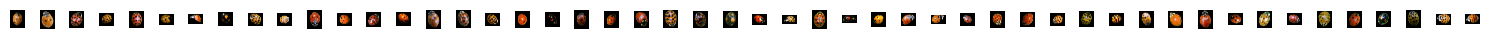

In [35]:
# Vérifier s'il y a des images dans la liste
if len(backgroundless_images) == 0:
    print("Aucune image trouvée dans le dossier.")
else:
    # Afficher les images
    fig, axes = plt.subplots(nrows=1, ncols=len(backgroundless_images), figsize=(15, 5))

    for i, image in enumerate(backgroundless_images):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


C:\Users\steve_ao846tt\AppData\Local\Temp\ipykernel_13484\3465917304.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_np = np.array(backgroundless_images)


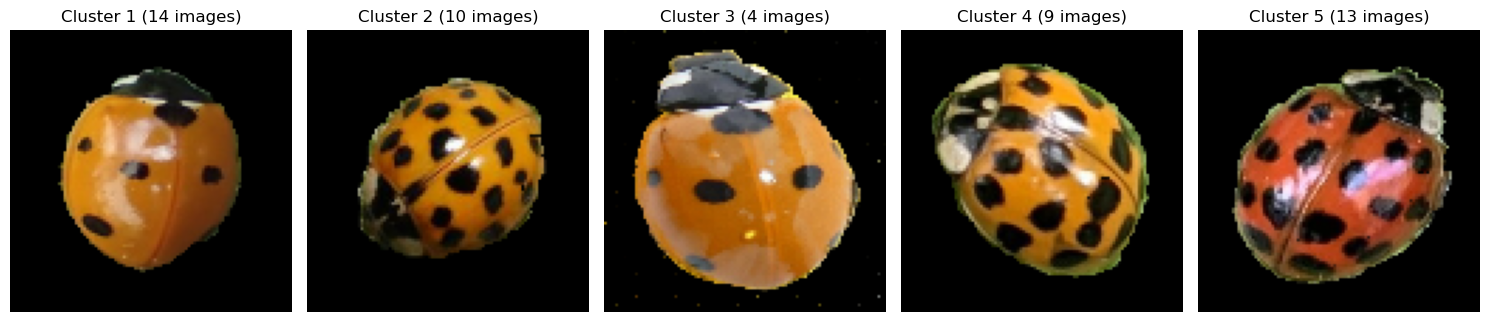

In [33]:
import glob
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Vérifier s'il y a des images dans la liste
if len(backgroundless_images) == 0:
    print("Aucune image trouvée dans le dossier.")
else:
    # Convertir les images en tableaux numpy
    images_np = np.array(backgroundless_images)

    # Redimensionner les images à une taille fixe
    desired_size = (100, 100)
    resized_images = []
    for image in images_np:
        resized_image = cv2.resize(image, desired_size)
        resized_images.append(resized_image)
    resized_images_np = np.array(resized_images)

    # Appliquer l'algorithme K-means sur les images redimensionnées
    n_samples, h, w, _ = resized_images_np.shape
    images_2d = resized_images_np.reshape((n_samples, h * w * 3))

    # Normaliser les valeurs des pixels entre 0 et 1
    images_2d = images_2d.astype(float) / 255

    # Appliquer l'algorithme de clustering K-means
    n_clusters = 5  # Nombre de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(images_2d)

    # Afficher les images avec leur cluster attribué
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(15, 5))

    for cluster in range(n_clusters):
        cluster_images = resized_images_np[labels == cluster]
        cluster_size = len(cluster_images)
        axes[cluster].imshow(cv2.cvtColor(cluster_images[0], cv2.COLOR_BGR2RGB))
        axes[cluster].set_title(f"Cluster {cluster+1} ({cluster_size} images)")
        axes[cluster].axis('off')

    plt.tight_layout()
    plt.show()


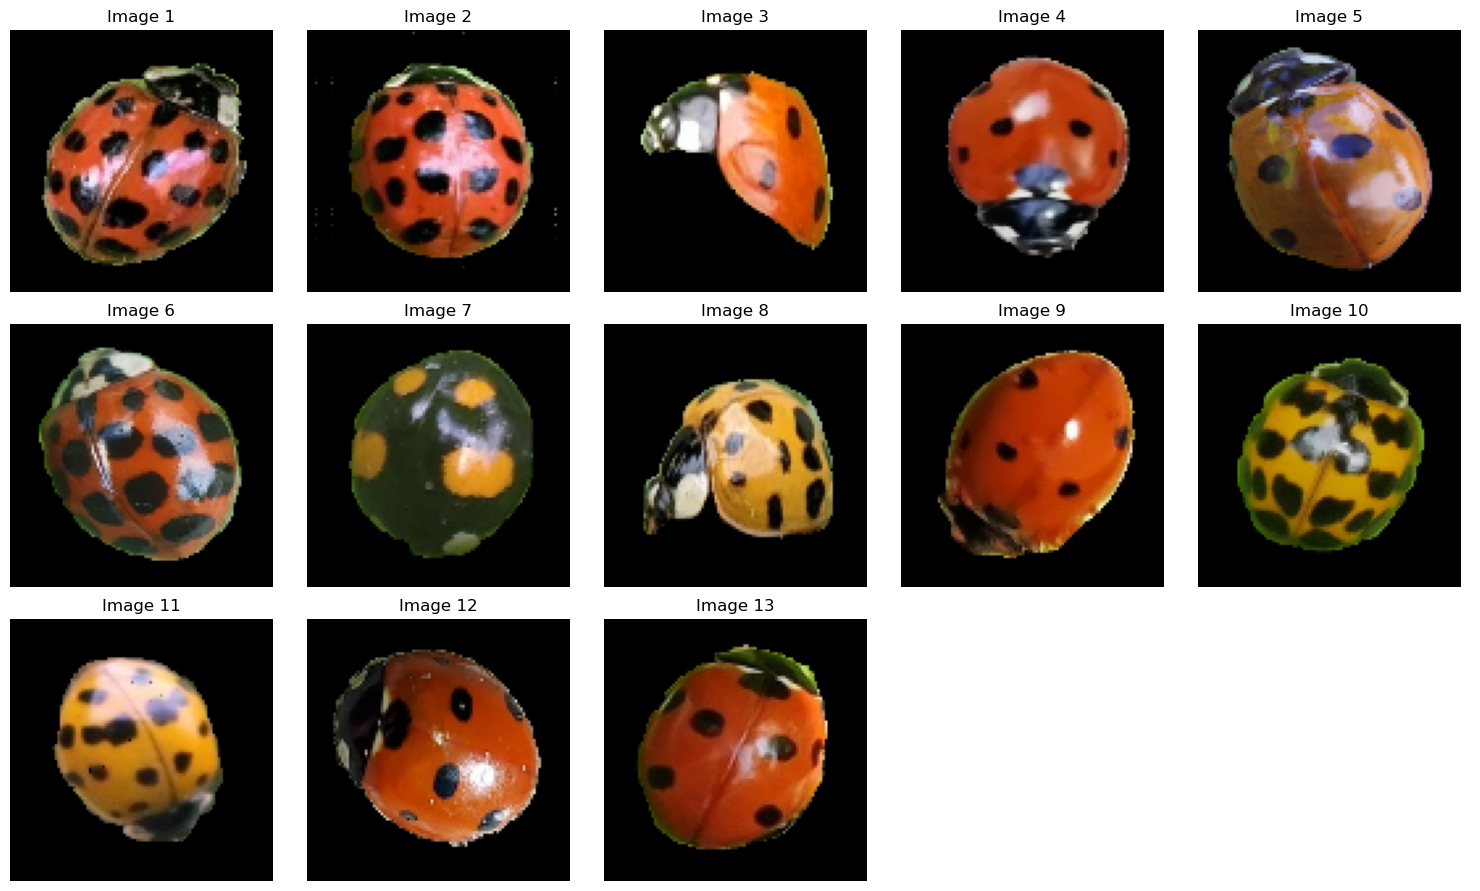

In [34]:
# Déterminer le numéro du cluster à observer (de 1 à n_clusters)
cluster_to_observe = 5

# Récupérer les images du cluster sélectionné
selected_cluster_images = resized_images_np[labels == cluster_to_observe - 1]
num_images = len(selected_cluster_images)

# Définir la taille de la grille de sous-parcelles
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

# Créer la grille de sous-parcelles pour afficher les images
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

# Parcourir les images et les afficher dans les sous-parcelles
for i, image in enumerate(selected_cluster_images):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

# Supprimer les sous-parcelles non utilisées
for j in range(num_images, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()
